# Transition pathway initiative - Conducting large scale carbon management evaluation with ChatGPT and Jiggybase.

1. Setting-up the knowledge base of climate disclosures
  - Locate folder path in drive
  - Upload, extract/clean, vectorize with Jiggybase sdk

2. Convert TPI methodology into prompts
  - List 19 TPI questions
  - Prompt engineering
  - Set up prompt routine

3. Prompt ChatGPT & Collect answers
  - GPT inference
  - Save answers

4. (Missing) Hard-code TPI maturity level


Key of the API : jgy-yjZCQzygEqNCuSyCftpNBzWkYimMmoDJMrPPgEVdLV

##Setting-up the knowledge base of climate disclosures
  - Locate folder path in drive
  - Upload, extract/clean, vectorize with Jiggybase sdk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install jiggybase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 17.7 MB/s eta 0:00:00


In [3]:
!pip install pydantic==1.10.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.2.1
    Uninstalling pydantic-2.2.1:
      Successfully uninstalled pydantic-2.2.1


In [4]:
import jiggybase
import jiggybase.collection
import jiggybase.models
import jiggybase.org
import os
import pandas as pd



jb = jiggybase.JiggyBase()

collection = jb.collection('Climate financial analyst')
folder_path = '/content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2'

# Set your organization and collection name
ORGANIZATION_NAME = 'elm09'
COLLECTION_NAME = 'Climate financial analyst'
org = jb.get_org(ORGANIZATION_NAME)

You can find your API Key here: https://jiggy.ai/authorize
Enter your JiggyBase API Key: jgy-yjZCQzygEqNCuSyCftpNBzWkYimMmoDJMrPPgEVdLV


##Convert TPI methodology into prompts
  - List 19 TPI questions (rf. TPI methodology)
  - Prompt engineering (pending - literature)
  - Set up prompt routine

In [5]:
import json

# List of companies
companies = [
    "Emerson Electric",
    "Spirit Airlines",
    "Antero Midstream",
    "Carpenter Tech",
    "Coterra Energy",
    "Eagle Materials",
    "Enterprise Products",
    "Hormel Foods",
    "APA Corporation",
    "Canadian Natural Resources",
    "Alaska Air",
    "Albemarle",
    "Alliant Energy",
    "Amphenol",
    "Pepsico",
    "Public Service Enterprise Group",
    "Trane Technologies",
    "Occidental Petroleum",
    "Apple",
    "PACCAR",
]

# Read the template file
with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/improved_template.txt', 'r') as file:
    template = file.read()


# Parse the content based on the delimiter '\n-'
prompts_template = template.split("\n-")
master_dict1 = {}

for company in companies:
    for i, prompt in enumerate(prompts_template):
        key = f"{company}{i+1}"
        master_dict1[key] = prompt.replace("X", company)

file_path = '/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/prompt_dictionary_engineered.txt'
with open(file_path, 'w') as json_file:
    json.dump(master_dict1, json_file, indent=4)


In [6]:
import jiggybase
from jiggybase.models import PromptMessage

# Initialize the collection
collection = jiggybase.JiggyBase().collection(COLLECTION_NAME)

# Iterate over the master_dict1
for key, prompt_content in master_dict1.items():
    # Extract company name and prompt number from the key
    company_name = ''.join([i for i in key if not i.isdigit()])  # Extracting letters from the key
    prompt_name = key  # Using the entire key as the prompt name

    # Create a PromptMessage for each prompt
    prompt_message = PromptMessage(
        content=prompt_content,
        role="user",
        position=1,
        extras=None,
    )

    # Create a task for each prompt
    task = org.create_prompt_task(
        name=prompt_name.replace(" ", "_"),  # Replace spaces with underscores in the prompt name
        version=1,
        prompts=[prompt_message],  # Wrap the prompt message in a list
        type=None,
        description=f"{company_name}_report"  # Use the company name in the description
    )

    # Get responses from the prompt task
    temperature = 0.05
    model = "gpt-3.5-turbo"

    response = collection._chat_completion(task.prompts, temperature=temperature, model=model)

    # Save the responses back to master_dict1
    if response.choices:
        response_content = response.choices[0].message.content
        print(f"Key: {key}\nResponse: {response_content}\n{'-'*50}")
        master_dict1[key] = {
            'prompt': prompt_content,
            'response': response_content
        }
    else:
        master_dict1[key] = {
            'prompt': prompt_content,
            'response': None
        }


Key: Emerson Electric1
Response: Yes Emerson Electric acknowledges climate change as a significant issue for the business. They have set greenhouse gas emission reduction targets and have published information on their operational greenhouse gas emissions.
--------------------------------------------------
Key: Emerson Electric2
Response: Yes Emerson Electric recognizes climate change as a relevant risk and opportunity for the business. In their 2022 Environmental, Social and Governance Report, Emerson states that they performed a climate scenario analysis to identify climate-related risks and opportunities that are most material to their business. They followed the recommendations of the Task Force on Climate-related Financial Disclosures (TCFD) and assessed a range of future climate-related scenarios. This demonstrates their recognition of climate change as a relevant factor for their business. (Source: Emerson Electric.txt)
--------------------------------------------------
Key: Eme

In [7]:
# Add 'pred_label' key to each entry in master_dict1 based on the response
for key, value in master_dict1.items():
    if value['response'] and value['response'].strip().lower().startswith("yes"):
        value['pred_label'] = 1
    else:
        value['pred_label'] = 0

#From text to json

In [ ]:
# import ast
# import json

# # Convert text content to dictionary
# def content_to_dict_updated(content):
#     """Converts the string content to a dictionary, handling lines without colons."""
#     lines = content.strip().split("\n")
#     result_dict = {}
#     for line in lines:
#         if ":" not in line:
#             continue
#         key, value_str = line.split(":", 1)
#         key = key.strip()
#         value_dict = ast.literal_eval(value_str.strip())
#         result_dict[key] = value_dict
#     return result_dict

# # Read the content of the text files
# with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/extractor_dict.txt', 'r') as file:
#     extractor_content = file.read()

# with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.txt', 'r') as file:
#     baseline_content = file.read()

# # Convert the content to dictionaries
# extractor_dict = content_to_dict_updated(extractor_content)
# baseline_dict = content_to_dict_updated(baseline_content)

# # Save the dictionaries as JSON files
# with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/extractor_dict.json', 'w') as file:
#     json.dump(extractor_dict, file)

# with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'w') as file:
#     json.dump(baseline_dict, file)

# # Load the dictionaries from JSON files (for future use)
# with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/extractor_dict.json', 'r') as file:
#     extractor_dict_loaded = json.load(file)

# with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'r') as file:
#     baseline_dict_loaded = json.load(file)


In [26]:
import json
import pandas as pd

# Load the data and the master dictionary
df = pd.read_csv('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/RepertoireEntreprises.csv')
df.replace({'Yes': 1, 'No': 0, 'Not applicable': 'N.A'}, inplace=True)

# Ask the user for the path to the dictionary they want to use
dict_path = input("Please enter the path to the dictionary you want to use: ")

# Load the specified dictionary
with open(dict_path, 'r') as file:
    master_dict1 = json.load(file)

# Create a dictionary for companies and their answers
companies = df['Company'].tolist()
questions_answers = df.iloc[:, 4:-3].values.tolist()
company_dict = dict(zip(companies, questions_answers))

# Map true labels
for key, value in master_dict1.items():
    company_name, question_number = ''.join(filter(lambda x: not x.isdigit(), key)), int(''.join(filter(str.isdigit, key)))
    if company_name in company_dict and question_number <= len(company_dict[company_name]):
        value['true_label'] = company_dict[company_name][question_number - 1]


KeyboardInterrupt: ignored

In [33]:
# Printing the entire dictionary
for key, value in extractor_dict.items():
    print(f'{key}: {value}')

Emerson Electric1: {'prompt': 'Does Emerson Electric acknowledge climate change as a significant issue for the business? (Yes, if Emerson Electric recognizes climate change as a relevant risk and/or opportunity for the business, Yes, if Emerson Electric has a policy or an equivalent statement committing them to take action on climate change, Yes, if Emerson Electric has set greenhouse gas emission reduction targets, Yes, if Emerson Electric has published information on their operational greenhouse gas emissions, No, if Emerson Electric does not meet any of the above criteria) ', 'response': 'Yes, Emerson Electric acknowledges climate change as a significant issue for the business. They have set greenhouse gas emission reduction targets and have published information on their operational greenhouse gas emissions.', 'pred_label': 1, 'true_label': 1}
Emerson Electric2: {'prompt': '\nDoes Emerson Electric recognize climate change as a relevant risk and/or opportunity for the business? (Yes

In [23]:
# Printing the entire dictionary
for key, value in master_dict1.items():
    print(f'{key}: {value}')

Emerson Electric1: {'prompt': 'Does Emerson Electric acknowledge climate change as a significant issue for the business? (Yes, if Emerson Electric recognizes climate change as a relevant risk and/or opportunity for the business, Yes, if Emerson Electric has a policy or an equivalent statement committing them to take action on climate change, Yes, if Emerson Electric has set greenhouse gas emission reduction targets, Yes, if Emerson Electric has published information on their operational greenhouse gas emissions, No, if Emerson Electric does not meet any of the above criteria) ', 'response': 'Yes Emerson Electric acknowledges climate change as a significant issue for the business. They have set greenhouse gas emission reduction targets and have published information on their operational greenhouse gas emissions.', 'pred_label': 1, 'true_label': 1}
Emerson Electric2: {'prompt': '\nDoes Emerson Electric recognize climate change as a relevant risk and/or opportunity for the business? (Yes,

In [24]:
# Save the dictionaries as JSON files
with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/engineered_dict.json', 'w') as file:
    json.dump(master_dict1, file)


#Evaluation

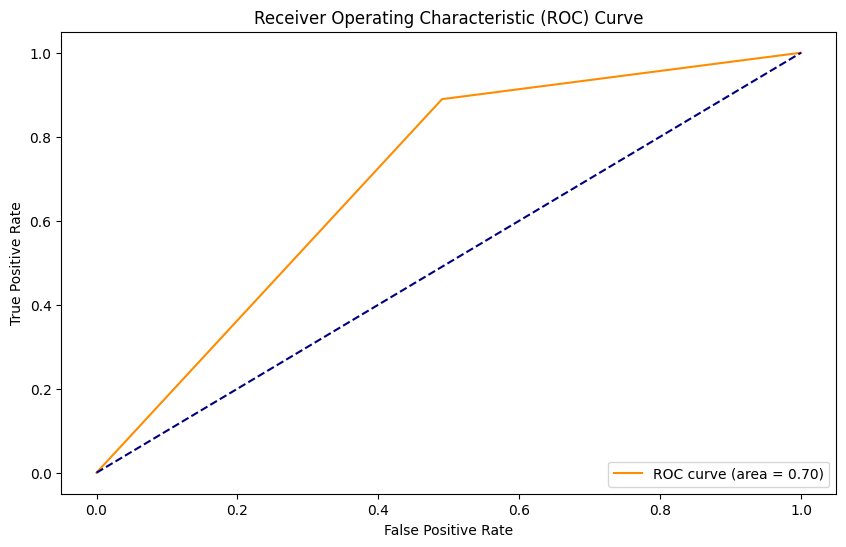

{'AUC Value': 0.6995139121689573, 'Accuracy': 0.7175792507204611, 'Precision': 0.6869918699186992, 'F1 Score': 0.7752293577981652}


In [11]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import auc, roc_curve, accuracy_score, precision_score, f1_score

all_true_labels = [value['true_label'] for key, value in master_dict1.items() if 'true_label' in value and value['true_label'] in [0, 1]]
all_pred_labels = [value['pred_label'] for key, value in master_dict1.items() if 'true_label' in value and value['true_label'] in [0, 1]]

# Filter for binary metrics calculation
filtered_true_labels = [label for label in all_true_labels if label in [0, 1]]
filtered_pred_labels = [all_pred_labels[i] for i, label in enumerate(all_true_labels) if label in [0, 1]]

# Overall metrics
auc_value = auc(*roc_curve(filtered_true_labels, filtered_pred_labels)[:2])
accuracy = accuracy_score(filtered_true_labels, filtered_pred_labels)
precision = precision_score(filtered_true_labels, filtered_pred_labels)
f1 = f1_score(filtered_true_labels, filtered_pred_labels)

# ROC Curve
fpr, tpr, _ = roc_curve(filtered_true_labels, filtered_pred_labels)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

metrics = {
    "AUC Value": auc_value,
    "Accuracy": accuracy,
    "Precision": precision,
    "F1 Score": f1
}

print(metrics)


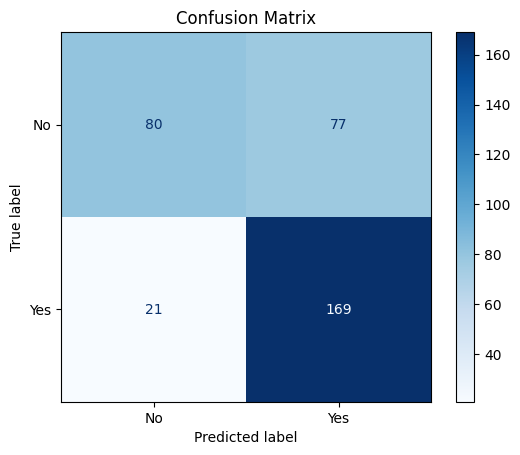

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(filtered_true_labels, filtered_pred_labels, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


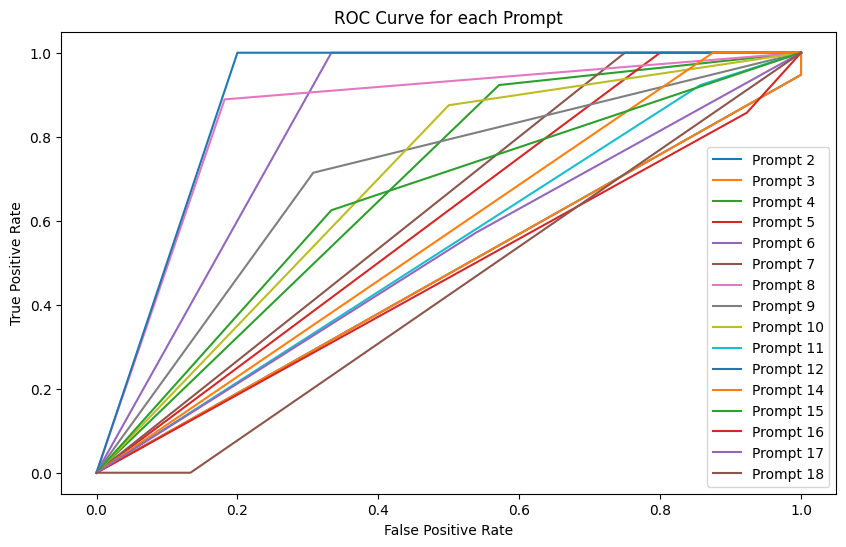

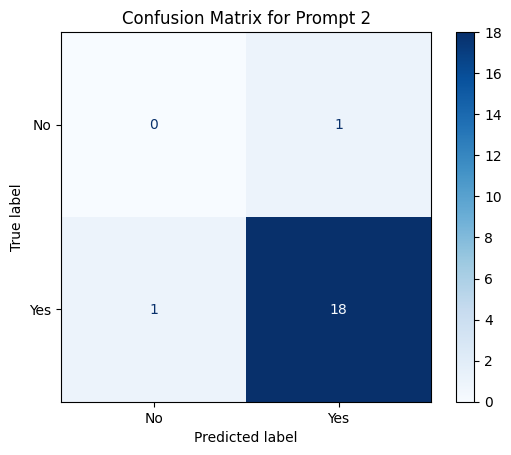

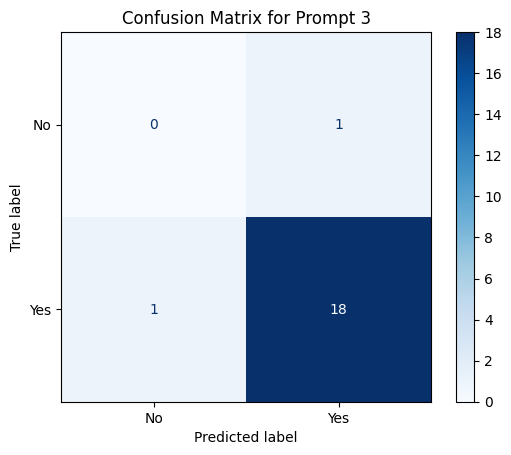

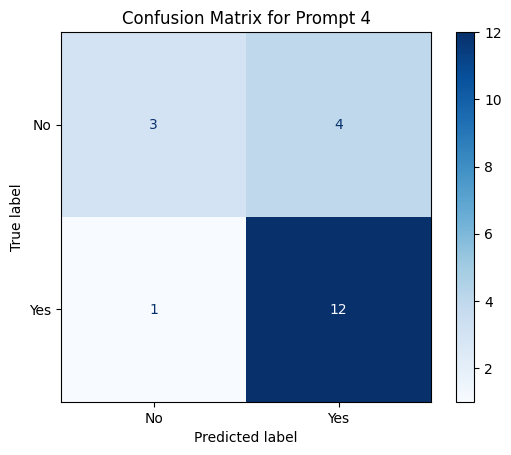

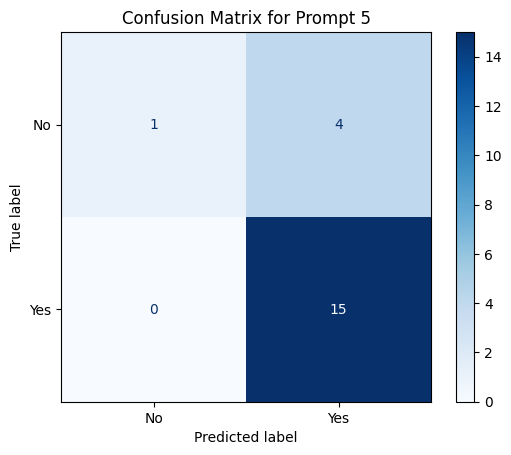

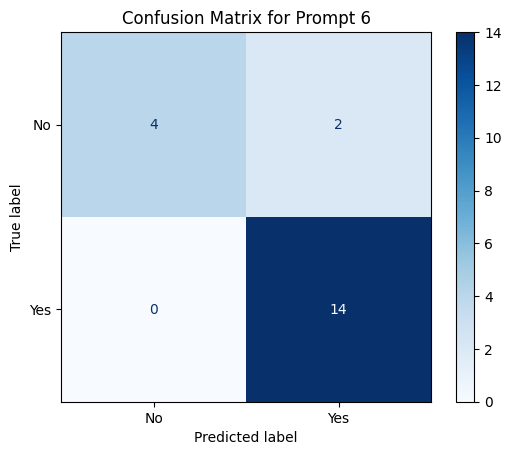

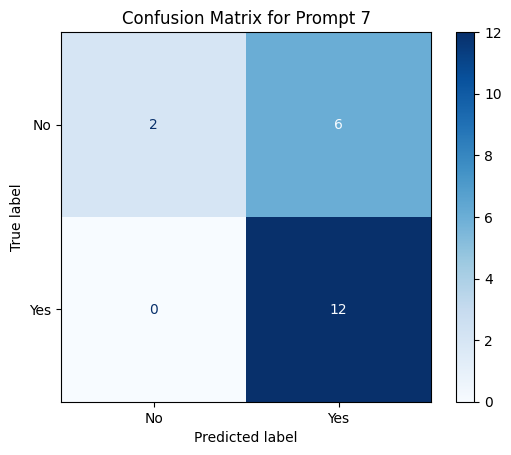

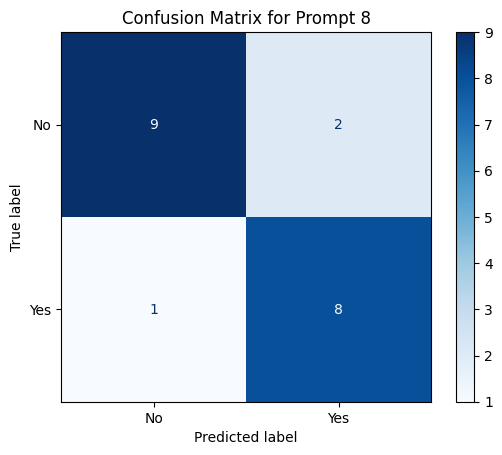

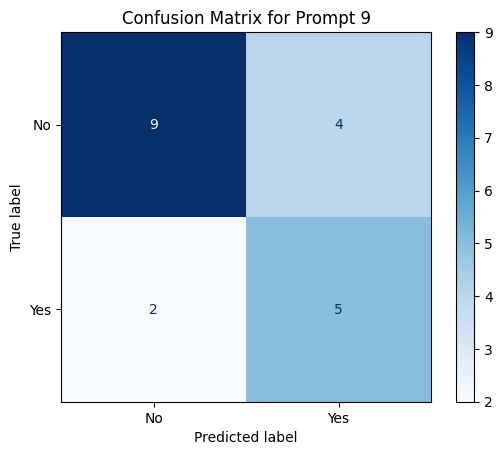

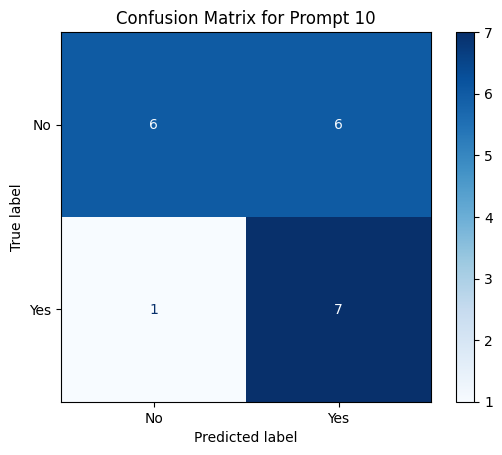

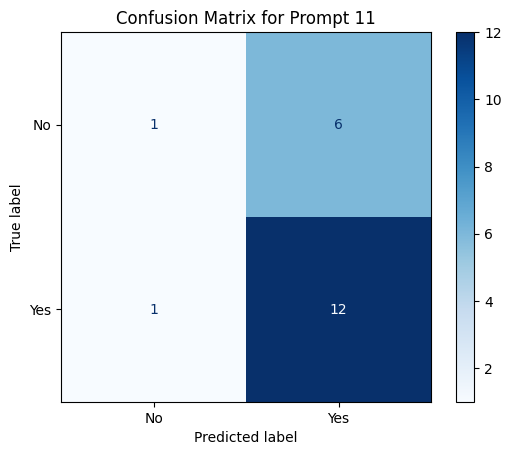

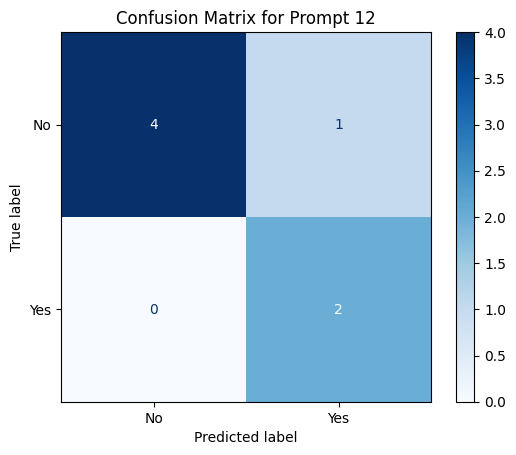

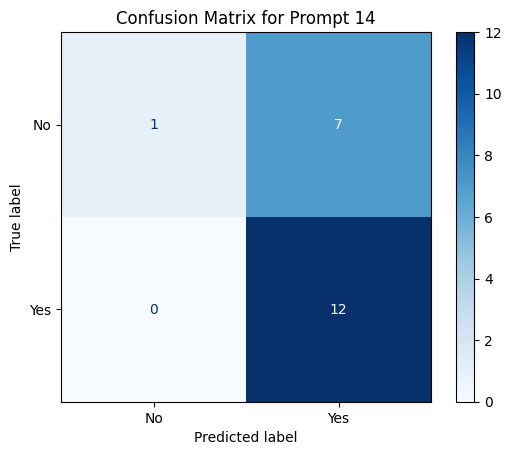

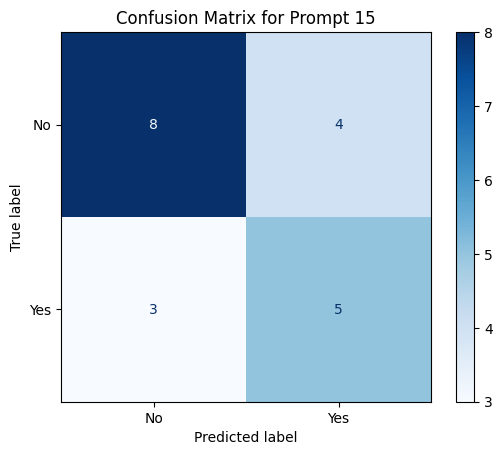

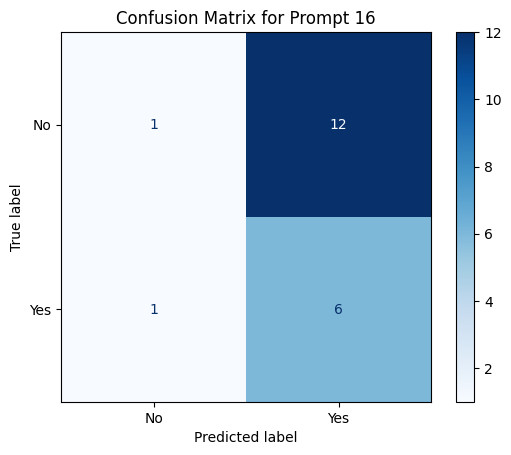

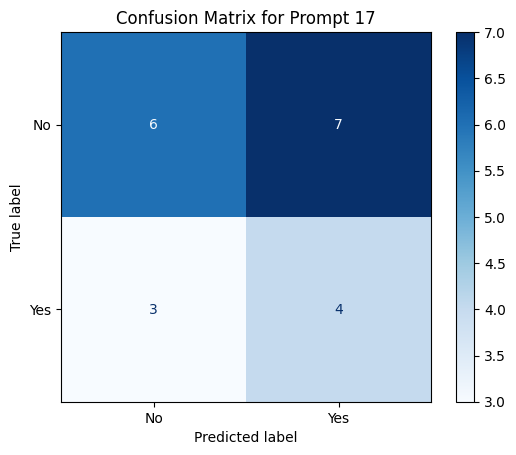

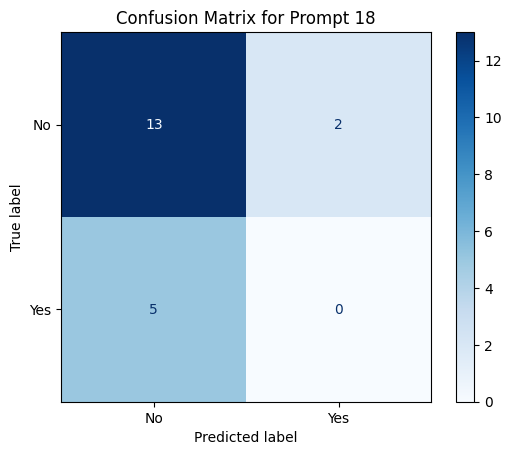

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Granular performance evaluation functions

def calculate_metrics(pred_labels, true_labels):
    # auc_val = auc(*roc_curve(true_labels, pred_labels)[:2])
    accuracy_val = accuracy_score(true_labels, pred_labels)
    precision_val = precision_score(true_labels, pred_labels)
    f1_val = f1_score(true_labels, pred_labels)

    return {
        # 'AUC': auc_val,
        'Accuracy': accuracy_val,
        'Precision': precision_val,
        'F1 Score': f1_val
    }

def extract_prompt_num(key):
    return int(''.join(filter(str.isdigit, key)))

prompt_performance = {}

# Modified ROC curve visualization for each prompt to handle cases with no positive or negative samples

plt.figure(figsize=(10, 6))
for i in range(1, 20):
    prompt_pred_labels = [entry['pred_label'] for key, entry in master_dict1.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]
    prompt_true_labels = [entry['true_label'] for key, entry in master_dict1.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]
    prompt_performance[f"Prompt {i}"] = calculate_metrics(prompt_pred_labels, prompt_true_labels)

    # Only plot ROC curve if both positive and negative samples exist
    if set(prompt_true_labels) == {0, 1}:
        fpr, tpr, _ = roc_curve(prompt_true_labels, prompt_pred_labels)
        plt.plot(fpr, tpr, label=f'Prompt {i}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each Prompt')
plt.legend(loc="lower right")
plt.show()

# Visualize the confusion matrix for each prompt again
for i in range(1, 20):
    prompt_pred_labels = [entry['pred_label'] for key, entry in master_dict1.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]
    prompt_true_labels = [entry['true_label'] for key, entry in master_dict1.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]

    # Only plot confusion matrix if both positive and negative samples exist
    if set(prompt_true_labels) == {0, 1}:
        cm = confusion_matrix(prompt_true_labels, prompt_pred_labels, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
        disp.plot(cmap="Blues")
        plt.title(f'Confusion Matrix for Prompt {i}')
        plt.show()




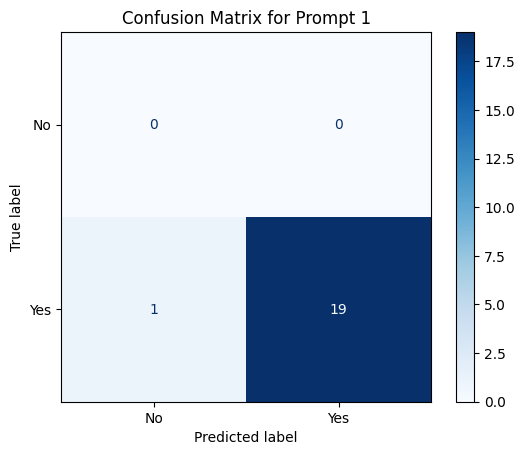

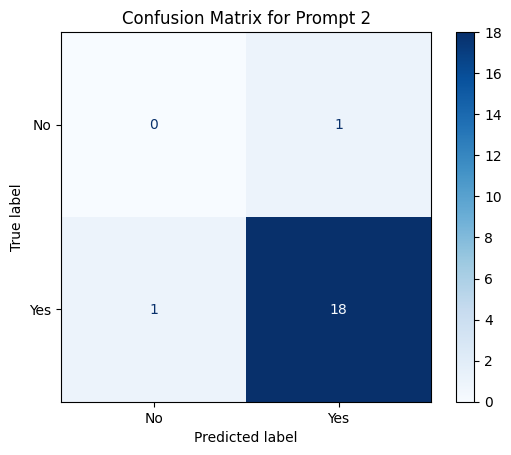

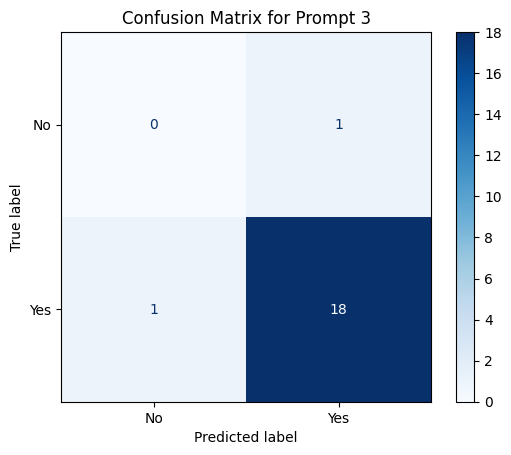

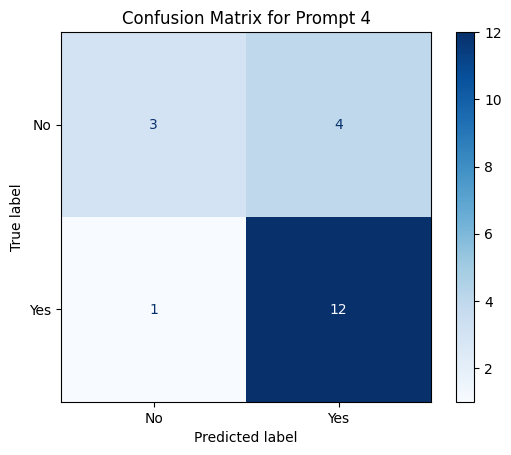

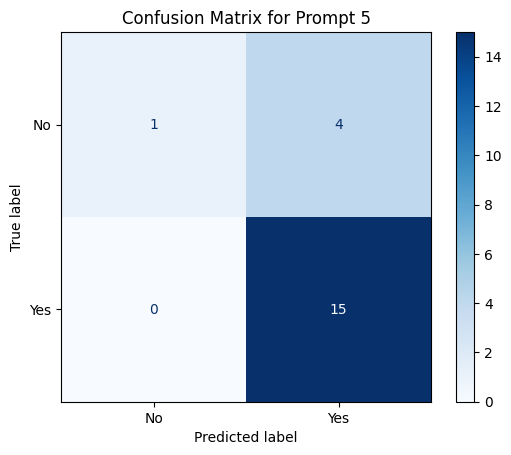

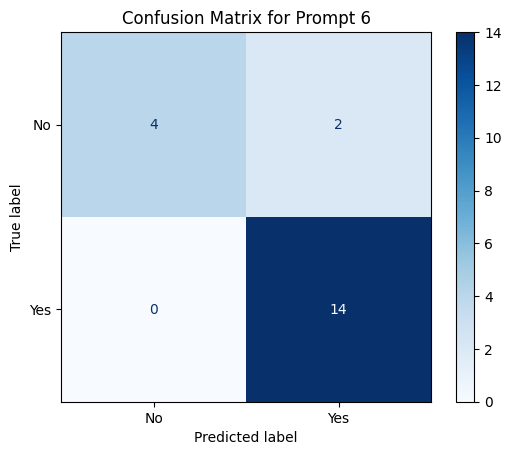

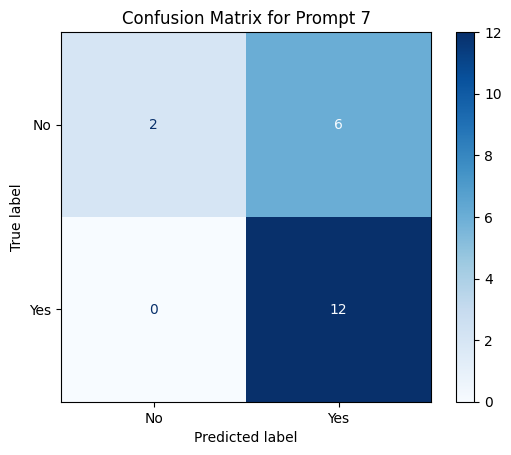

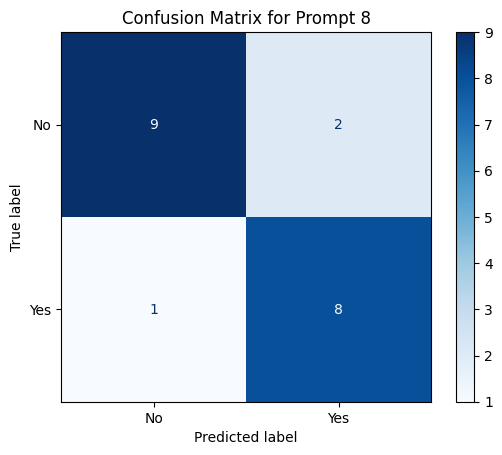

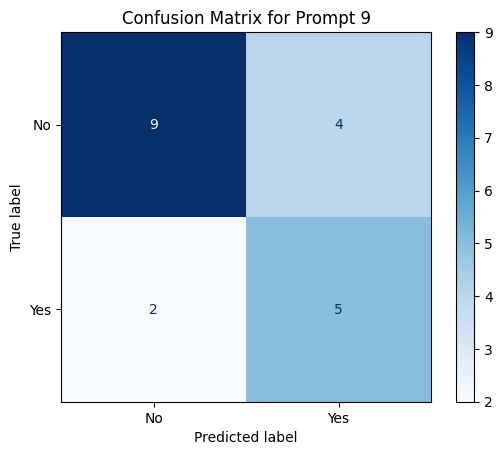

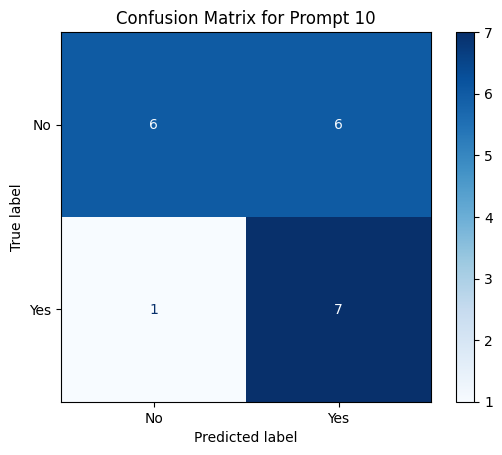

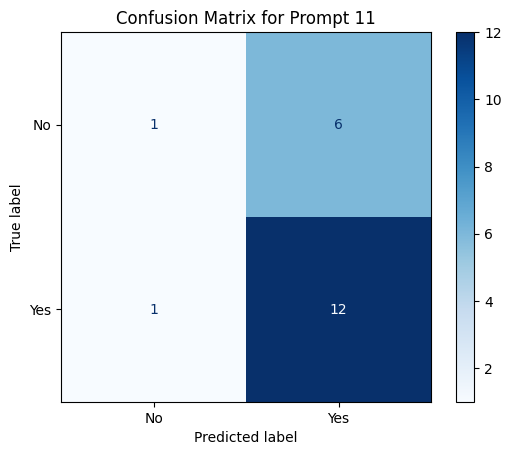

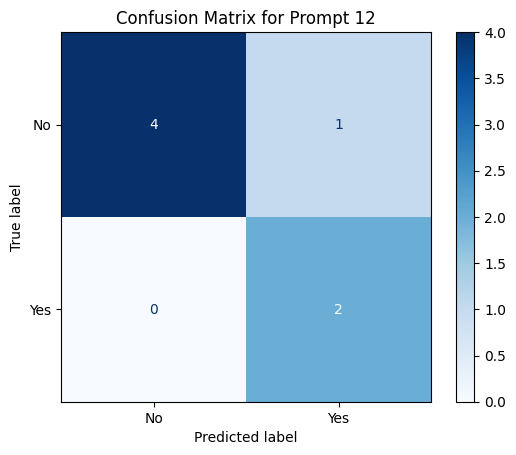

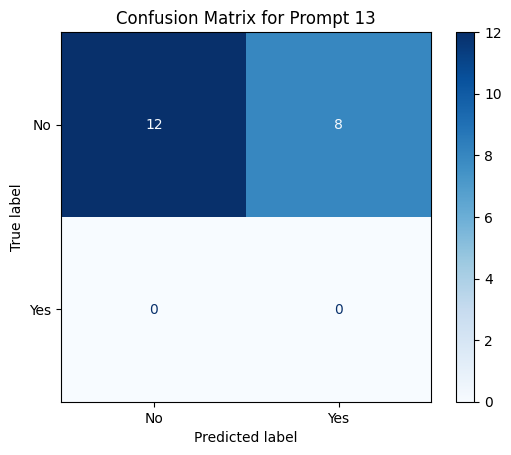

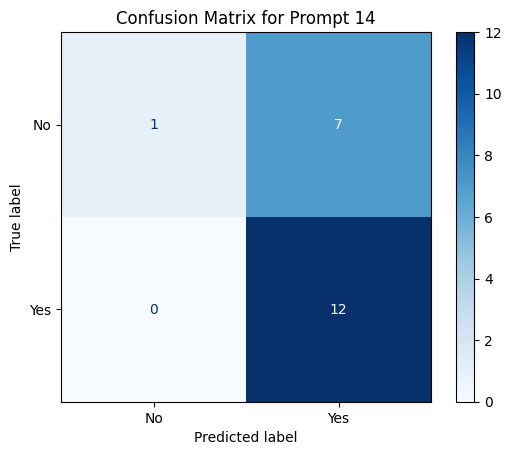

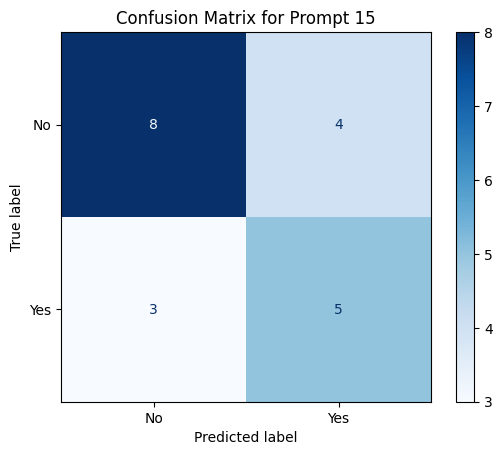

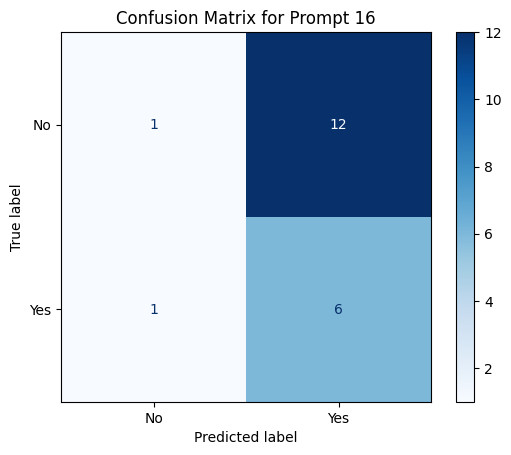

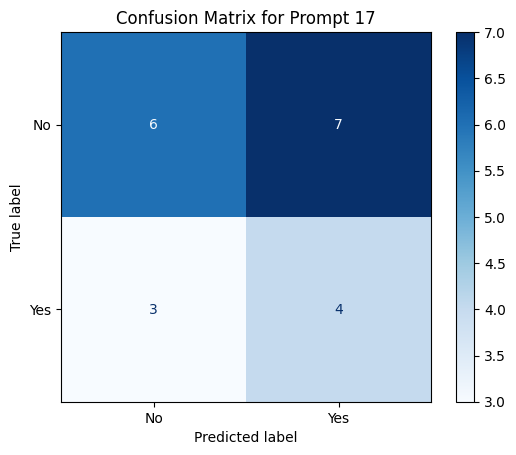

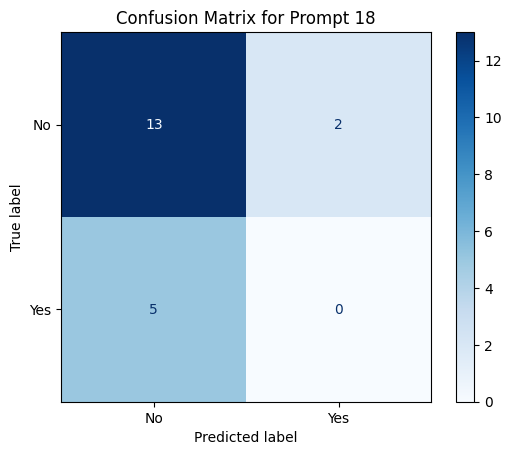

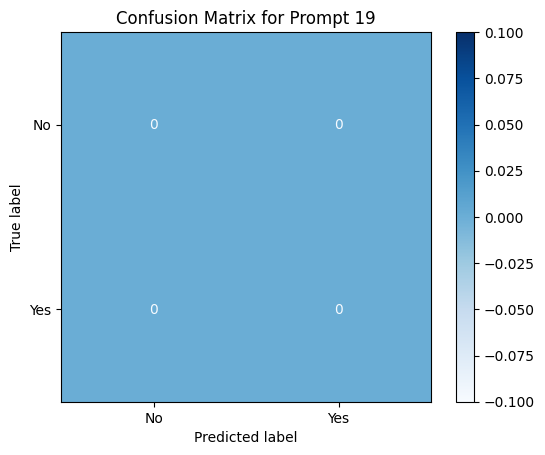

In [14]:
# Visualize the confusion matrix for each prompt
for i in range(1, 20):
    prompt_pred_labels = [entry['pred_label'] for key, entry in master_dict1.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]
    prompt_true_labels = [entry['true_label'] for key, entry in master_dict1.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]
    cm = confusion_matrix(prompt_true_labels, prompt_pred_labels, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(cmap="Blues")
    plt.title(f'Confusion Matrix for Prompt {i}')
    plt.show()


In [21]:
prompt_performance

{'Prompt 1': {'Accuracy': 0.95,
  'Precision': 1.0,
  'F1 Score': 0.9743589743589743},
 'Prompt 2': {'Accuracy': 0.9,
  'Precision': 0.9473684210526315,
  'F1 Score': 0.9473684210526315},
 'Prompt 3': {'Accuracy': 0.9,
  'Precision': 0.9473684210526315,
  'F1 Score': 0.9473684210526315},
 'Prompt 4': {'Accuracy': 0.75,
  'Precision': 0.75,
  'F1 Score': 0.8275862068965517},
 'Prompt 5': {'Accuracy': 0.8,
  'Precision': 0.7894736842105263,
  'F1 Score': 0.8823529411764706},
 'Prompt 6': {'Accuracy': 0.9,
  'Precision': 0.875,
  'F1 Score': 0.9333333333333333},
 'Prompt 7': {'Accuracy': 0.7,
  'Precision': 0.6666666666666666,
  'F1 Score': 0.8},
 'Prompt 8': {'Accuracy': 0.85,
  'Precision': 0.8,
  'F1 Score': 0.8421052631578948},
 'Prompt 9': {'Accuracy': 0.7,
  'Precision': 0.5555555555555556,
  'F1 Score': 0.6250000000000001},
 'Prompt 10': {'Accuracy': 0.65,
  'Precision': 0.5384615384615384,
  'F1 Score': 0.6666666666666667},
 'Prompt 11': {'Accuracy': 0.65,
  'Precision': 0.6666666

#Label distribution

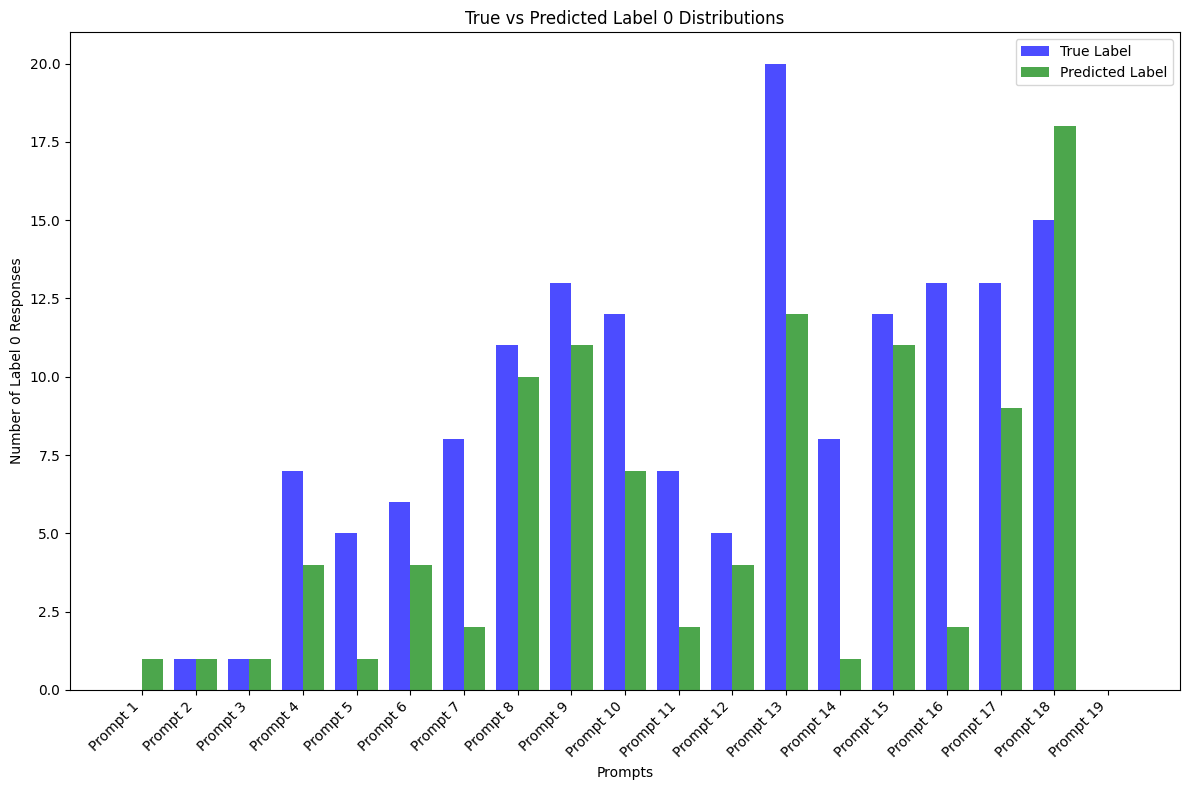

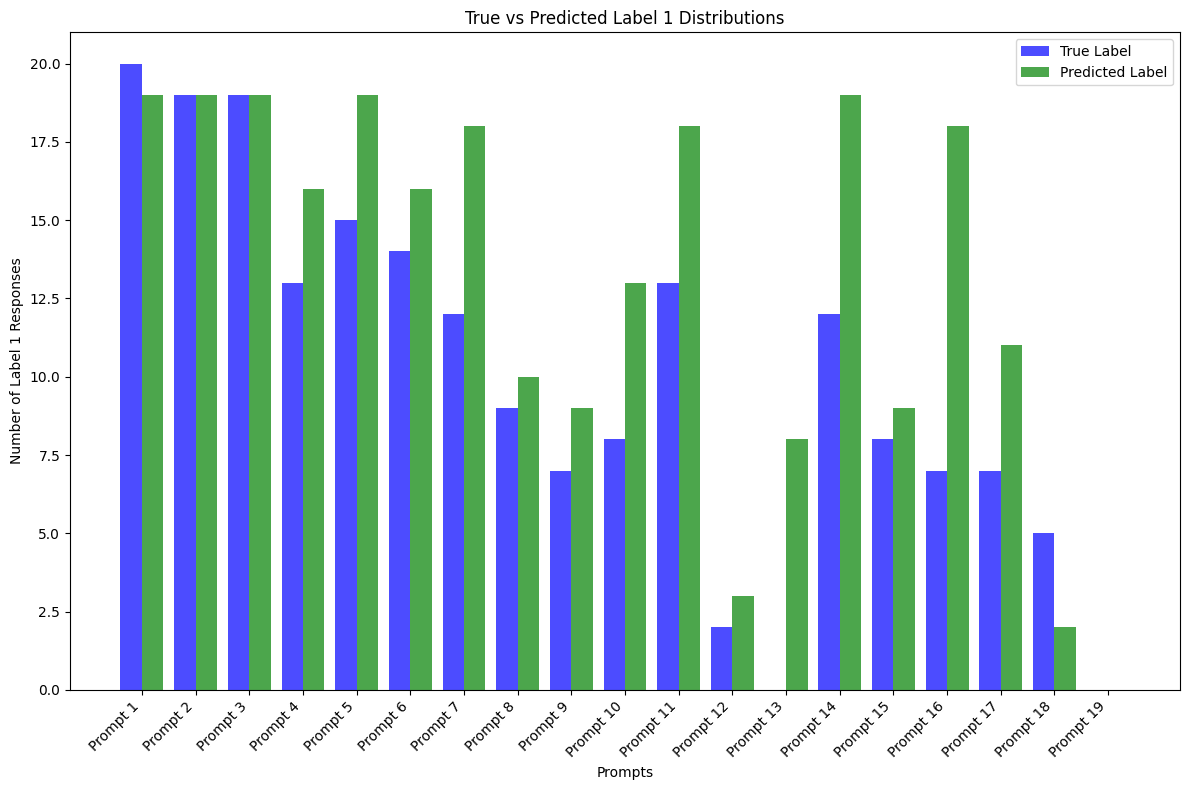

In [16]:
import json
import pandas as pd
import matplotlib.pyplot as plt

def extract_prompt_num(key):
    """Function to extract prompt number from key."""
    return int(''.join(filter(str.isdigit, key)))

def label_distribution_for_prompts(data_dict, label_value):
    """Compute label distribution for each prompt for a given label value."""
    distribution_true = {}
    distribution_pred = {}

    for i in range(1, 20):
        true_labels = [entry['true_label'] for key, entry in data_dict.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]
        pred_labels = [entry['pred_label'] for key, entry in data_dict.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]

        distribution_true[f"Prompt {i}"] = true_labels.count(label_value)
        distribution_pred[f"Prompt {i}"] = pred_labels.count(label_value)

    return distribution_true, distribution_pred

def plot_label_distributions(distribution_true, distribution_pred, label_value):
    """Plot the label distributions for a given label value."""
    prompts = list(distribution_true.keys())
    true_values = list(distribution_true.values())
    pred_values = list(distribution_pred.values())

    fig, ax = plt.subplots(figsize=(12, 8))
    width = 0.4
    x = range(len(prompts))

    ax.bar([i - width/2 for i in x], true_values, width=width, label='True Label', color='blue', alpha=0.7)
    ax.bar([i + width/2 for i in x], pred_values, width=width, label='Predicted Label', color='green', alpha=0.7)

    ax.set_title(f'True vs Predicted Label {label_value} Distributions')
    ax.set_xlabel('Prompts')
    ax.set_ylabel(f'Number of Label {label_value} Responses')
    ax.set_xticks(x)
    ax.set_xticklabels(prompts, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Compute and plot label distributions for label 0
distribution_true_0, distribution_pred_0 = label_distribution_for_prompts(master_dict1, 0)
plot_label_distributions(distribution_true_0, distribution_pred_0, 0)

# Compute and plot label distributions for label 1
distribution_true_1, distribution_pred_1 = label_distribution_for_prompts(master_dict1, 1)
plot_label_distributions(distribution_true_1, distribution_pred_1, 1)

In [17]:
def evaluate_dictionary(master_dict):
    prompt_performance = {}
    for i in range(1, 20):
        prompt_pred_labels = [entry['pred_label'] for key, entry in master_dict.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]
        prompt_true_labels = [entry['true_label'] for key, entry in master_dict.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]

        # Initialize default metrics as 'N/A'
        prompt_metrics = {
            'AUC': 'N/A',
            'Accuracy': 'N/A',
            'Precision': 'N/A',
            'F1 Score': 'N/A'
        }

        # Always compute accuracy
        prompt_metrics['Accuracy'] = accuracy_score(prompt_true_labels, prompt_pred_labels)

        # Check if both classes are present before computing other metrics
        if len(set(prompt_true_labels)) == 2:
            other_metrics = calculate_metrics(prompt_pred_labels, prompt_true_labels)
            prompt_metrics.update(other_metrics)  # Update the metrics for the current prompt

        prompt_performance[f"Prompt {i}"] = prompt_metrics

    return prompt_performance


In [18]:
copy = master_dict1

In [47]:
def are_dicts_equal(dict1, dict2):
    if dict1 == dict2:
        return True

    # Check for keys in dict1 but not in dict2
    for key in dict1:
        if key not in dict2:
            print(f"Key '{key}' found in dict1 but not in dict2.")
        elif dict1[key] != dict2[key]:
            print(f"Key '{key}' has different values: {dict1[key]} (dict1) vs {dict2[key]} (dict2).")

    # Check for keys in dict2 but not in dict1
    for key in dict2:
        if key not in dict1:
            print(f"Key '{key}' found in dict2 but not in dict1.")

    return False


if are_dicts_equal(engineered_dict, perso_dict):
    print("The dictionaries are identical.")
else:
    print("The dictionaries are not identical.")

Key 'Emerson Electric1' has different values: {'prompt': 'Does Emerson Electric acknowledge climate change as a significant issue for the business? (Yes, if Emerson Electric recognizes climate change as a relevant risk and/or opportunity for the business, Yes, if Emerson Electric has a policy or an equivalent statement committing them to take action on climate change, Yes, if Emerson Electric has set greenhouse gas emission reduction targets, Yes, if Emerson Electric has published information on their operational greenhouse gas emissions, No, if Emerson Electric does not meet any of the above criteria) ', 'response': 'Yes Emerson Electric acknowledges climate change as a significant issue for the business. They have set greenhouse gas emission reduction targets and have published information on their operational greenhouse gas emissions.', 'pred_label': 1, 'true_label': 1} (dict1) vs {'prompt': 'Does Emerson Electric acknowledge climate change as a significant issue for the business? (

In [35]:

# Load the dictionaries from JSON files (for future use)
with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/engineered_dict.json', 'r') as file:
    engineered_dict = json.load(file)

with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/perso_dict.json', 'r') as file:
    perso_dict = json.load(file)

perso_performance = evaluate_dictionary(perso_dict)
engineered_performance = evaluate_dictionary(engineered_dict)

# Generate the table of accuracy for each prompt
data = {
    'Prompt': [f"Prompt {i}" for i in range(1, 20)],
    'Perso Accuracy': [perso_performance[f"Prompt {i}"]['Accuracy'] for i in range(1, 20)],
    'Engineered Accuracy': [engineered_performance[f"Prompt {i}"]['Accuracy'] for i in range(1, 20)]
}
df_table = pd.DataFrame(data)
df_table


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Prompt,Perso Accuracy,Engineered Accuracy
0,Prompt 1,0.950000,0.950000
1,Prompt 2,1.000000,0.900000
2,Prompt 3,0.850000,0.900000
3,Prompt 4,0.750000,0.750000
4,Prompt 5,0.750000,0.800000
5,Prompt 6,0.900000,0.900000
6,Prompt 7,0.700000,0.700000
7,Prompt 8,0.900000,0.850000
8,Prompt 9,0.700000,0.700000
9,Prompt 10,0.500000,0.650000


In [53]:
import pandas as pd
from scipy.stats import ttest_rel

def evaluate_dictionary(master_dict):
    prompt_performance = {}
    for i in range(1, 20):
        prompt_pred_labels = [entry['pred_label'] for key, entry in master_dict.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]
        prompt_true_labels = [entry['true_label'] for key, entry in master_dict.items() if 'true_label' in entry and extract_prompt_num(key) == i and isinstance(entry['true_label'], int) and entry['true_label'] in [0, 1]]

        # Always compute accuracy
        accuracy_val = accuracy_score(prompt_true_labels, prompt_pred_labels)

        prompt_performance[f"Prompt {i}"] = {'Accuracy': accuracy_val}
        # Check if both classes are present before computing other metrics
        if len(set(prompt_true_labels)) == 2:
            other_metrics = calculate_metrics(prompt_pred_labels, prompt_true_labels)
            prompt_performance[f"Prompt {i}"].update(other_metrics)  # Update the metrics for the current prompt

    return prompt_performance

v1_performance = evaluate_dictionary(perso_dict)
v2_performance = evaluate_dictionary(engineered_dict)

# Compute the differences and test for statistical significance
data_diff = {
    'Prompt': [],
    'Accuracy Difference': []}

df_diff = pd.DataFrame(data_diff)
df_diff


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Prompt,Accuracy Difference


#Comparing dictionaries

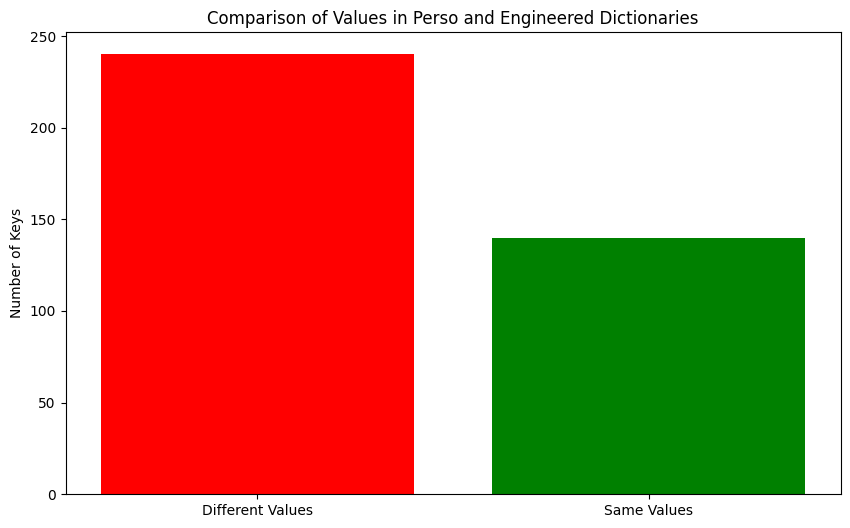

[{'Key': 'PACCAR19',
  'perso Value': {'prompt': '\nDoes PACCAR ensure consistency between its climate change policy and the positions taken by trade associations of which it is a member? (Yes, if PACCAR has a stated policy or commitment to ensure consistency between their climate change policy and the position taken by the trade associations of which they are members, No, if PACCAR does not have a stated policy or commitment to ensure consistency between their climate change policy and the position taken by the trade associations of which they are members) ',
   'response': "Yes, PACCAR ensures consistency between its climate change policy and the positions taken by trade associations of which it is a member. According to the PACCAR SASB-ESG Report 2023, PACCAR is a member of trade associations including the Truck and Engine Manufacturers Association, National Association of Manufacturers, American Trucking Associations, and others. These trade associations provide a collective indust

In [52]:
import json
import matplotlib.pyplot as plt


# Compare the keys
perso_keys = set(perso_dict.keys())
engineered_keys = set(engineered_dict.keys())

# Identify keys for which the values differ, ensuring the key exists in both dictionaries
different_values_keys = [key for key in perso_keys if key in engineered_keys and perso_dict[key] != engineered_dict[key]]

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(["Different Values", "Same Values"], [len(different_values_keys), len(perso_keys) - len(different_values_keys)], color=['red', 'green'])
plt.title("Comparison of Values in Perso and Engineered Dictionaries")
plt.ylabel("Number of Keys")
plt.show()

#  Side-by-side comparison for a subset
subset_keys_debug = different_values_keys[:5]
comparison_data_debug = []

for key in subset_keys_debug:
    comparison_data_debug.append({
        "Key": key,
        "perso Value": perso_dict[key],
        "Extractor Value": engineered_dict[key]
    })

comparison_data_debug


#Analyzing the 19th prompt

In [62]:
# Extract all entries related to the 19th prompt of each company from the baseline_dict
company_19th_entries = {}

for key, value in engineered_dict.items():
    if "13" in key:
        company_name = ''.join(filter(lambda x: not x.isdigit(), key))
        company_19th_entries[company_name] = value

# Convert to DataFrame for better presentation
df_19th_entries = pd.DataFrame.from_dict(company_19th_entries, orient='index')
df_19th_entries.reset_index(inplace=True)
df_19th_entries.rename(columns={"index": "Company"}, inplace=True)
df_19th_entries


,Company,prompt,response,pred_label,true_label
0,Emerson Electric,\nDoes Emerson Electric disclose its membershi...,"Yes, Emerson Electric discloses its membership...",1,0
1,Spirit Airlines,\nDoes Spirit Airlines disclose its membership...,No. The information retrieved from the search ...,0,0
2,Antero Midstream,\nDoes Antero Midstream disclose its membershi...,"No, Antero Midstream does not disclose its mem...",0,0
3,Carpenter Tech,\nDoes Carpenter Tech disclose its membership ...,No The provided information does not disclose ...,0,0
4,Coterra Energy,\nDoes Coterra Energy disclose its membership ...,"Yes, Coterra Energy discloses its membership a...",1,0
5,Eagle Materials,\nDoes Eagle Materials disclose its membership...,No Eagle Materials does not disclose its membe...,0,0
6,Enterprise Products,\nDoes Enterprise Products disclose its member...,No.,0,0
7,Hormel Foods,\nDoes Hormel Foods disclose its membership an...,No.,0,0
8,APA Corporation,\nDoes APA Corporation disclose its membership...,"No, APA Corporation does not disclose its memb...",0,0
9,Canadian Natural Resources,\nDoes Canadian Natural Resources disclose its...,"Yes, Canadian Natural Resources discloses its ...",1,0


#Printing responses next to each other :

In [55]:
# from IPython.display import display, HTML

# def generate_comparison_table(baseline, extractor):
#     # Start the HTML table
#     table_html = "<table border='1' style='width:100%; border-collapse: collapse;'>"

#     # Add headers
#     table_html += "<thead><tr><th>Prompt</th><th>Baseline Response</th><th>Extractor Response</th></tr></thead><tbody>"

#     # Iterate over the baseline dictionary to fill in the table rows
#     for key, item in baseline.items():
#         if key in extractor:
#             baseline_response = item["response"]
#             extractor_response = extractor[key]["response"]

#             # Highlight the row if responses differ
#             row_color = "background-color: #FFD6D6!important;" #    if baseline_response != extractor_response else ""


#             # Add the row to the table
#             table_html += f"<tr style='{row_color}'>"
#             table_html += f"<td>{item['prompt']}</td>"
#             table_html += f"<td>{baseline_response}</td>"
#             table_html += f"<td>{extractor_response}</td>"
#             table_html += "</tr>"

#     # Close the table
#     table_html += "</tbody></table>"

#     return table_html

# # Generate the table
# comparison_table_ExtraVsPerso = generate_comparison_table(perso_dict, extractor_dict)

# # Display the table
# display(HTML(comparison_table_ExtraVsPerso))


# # Save the generated HTML table to a file
# output_path = "/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/comparison_tableExtractorVSPerso.html"

# with open(output_path, "w") as file:
#     file.write(comparison_table_ExtraVsPerso)



Prompt,Baseline Response,Extractor Response
"Does Emerson Electric acknowledge climate change as a significant issue for the business? (Yes, if Emerson Electric recognizes climate change as a relevant risk and/or opportunity for the business, Yes, if Emerson Electric has a policy or an equivalent statement committing them to take action on climate change, Yes, if Emerson Electric has set greenhouse gas emission reduction targets, Yes, if Emerson Electric has published information on their operational greenhouse gas emissions, No, if Emerson Electric does not meet any of the above criteria)","Yes, Emerson Electric acknowledges climate change as a significant issue for the business. They have set greenhouse gas emission reduction targets and have published information on their operational greenhouse gas emissions.","Yes, Emerson Electric acknowledges climate change as a significant issue for the business. They have set greenhouse gas emission reduction targets and have published information on their operational greenhouse gas emissions."
"Does Emerson Electric recognize climate change as a relevant risk and/or opportunity for the business? (Yes, if Emerson Electric demonstrates recognition of climate change as a relevant risk and/or opportunity to the business, Yes, if Emerson Electric has a process to manage climate-related risks, Yes, if Emerson Electric has set long-term quantitative targets for reducing their greenhouse gas emissions, Yes, if Emerson Electric incorporates climate change performance into remuneration for senior executives, Yes, if Emerson Electric incorporates climate change risks and opportunities in their strategy, Yes, if Emerson Electric undertakes climate scenario planning, Yes, if Emerson Electric discloses an internal price of carbon, Yes, if Emerson Electric ensures consistency between their climate change policies and the positions taken by trade associations of which they are members, No, if Emerson Electric does not meet any of the above criteria)","Yes, Emerson Electric recognizes climate change as a relevant risk and opportunity for the business. In their 2022 Environmental, Social and Governance Report, Emerson states that they performed a climate scenario analysis to identify climate-related risks and opportunities that are most material to their business. They followed the recommendations of the Task Force on Climate-related Financial Disclosures (TCFD) and assessed a range of future climate-related scenarios, including a scenario based on the 2015 Paris Agreement objective of limiting global average temperature rise to below 2 degrees Celsius. This demonstrates their recognition of climate change as a relevant risk and opportunity. (Source: Emerson Electric.txt)","Yes, Emerson Electric recognizes climate change as a relevant risk and opportunity for the business. In their 2022 Environmental, Social and Governance Report, Emerson states that they performed a climate scenario analysis to identify climate-related risks and opportunities that are most material to their business. They followed the recommendations of the Task Force on Climate-related Financial Disclosures (TCFD) and assessed a range of future climate-related scenarios, including a scenario based on the 2015 Paris Agreement objective of limiting global average temperature rise to below 2 degrees Celsius. This demonstrates their recognition of climate change as a relevant risk and opportunity. (Source: Emerson Electric.txt)"
"Does Emerson Electric have a policy (or equivalent) commitment to action on climate change? (Yes, if Emerson Electric has a published policy or commitment statement on climate change that commits them to addressing the issue, No, if Emerson Electric does not have a policy or commitment statement on climate change)","Yes, Emerson Electric has a policy commitment to action on climate change. In their 2022 Environmental, Social and Governance Report, Emerson states that they have established a target to reach net z

#Missing true label for extractor dict

In [56]:
# Identify the keys where the content (specifically the "prompt" field) differs
different_prompt_keys = [key for key in different_values_keys if perso_dict[key]['prompt'] != engineered_dict[key]['prompt']]

# Extract the differences in the "prompt" field for these keys
prompt_differences = {}
for key in different_prompt_keys:
    prompt_differences[key] = {
        "perso Prompt": perso_dict[key]['prompt'],
        "Extractor Prompt": engineered_dict[key]['prompt']
    }

# Identify keys that lack the "true_label" field in the extractor_dict
keys_lacking_true_label = [key for key in engineered_dict if 'true_label' not in engineered_dict[key]]

len(different_prompt_keys), len(keys_lacking_true_label), prompt_differences

# Displaying the keys that lack the "true_label" field
keys_lacking_true_label


['Emerson Electric19',
 'Spirit Airlines19',
 'Antero Midstream19',
 'Carpenter Tech19',
 'Coterra Energy19',
 'Eagle Materials19',
 'Enterprise Products19',
 'Hormel Foods19',
 'APA Corporation19',
 'Canadian Natural Resources19',
 'Alaska Air19',
 'Albemarle19',
 'Alliant Energy19',
 'Amphenol19',
 'Pepsico19',
 'Public Service Enterprise Group19',
 'Trane Technologies19',
 'Occidental Petroleum19',
 'Apple19',
 'PACCAR19']

# Upload files

In [ ]:
import os


FOLDER_PATH = '/content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2'


def upload_file(collection, filename):
    print(f'Uploading {filename}')
    try:
        collection.upsert_file(filename)
    except Exception as e:
        print(f'Error on {filename}: {e}')

def upload_directory(collection, dirname):
    for fn in os.listdir(dirname):
        fn = os.path.join(dirname, fn)
        upload_file(collection, fn)

def main():
    org = jb.get_org(ORGANIZATION_NAME)
    collection = org.collection(COLLECTION_NAME)

    if os.path.isfile(FOLDER_PATH):
        upload_file(collection, FOLDER_PATH)
    elif os.path.isdir(FOLDER_PATH):
        upload_directory(collection, FOLDER_PATH)
    else:
        print(f"The path provided is not a valid file or directory: {FOLDER_PATH}")

if __name__ == "__main__":
    main()


Uploading /content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2/APA Corporation.txt
Uploading /content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2/Alaska Air.txt
Uploading /content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2/PACCAR.txt
Uploading /content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2/Alliant Energy.txt
Uploading /content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2/Albemarle.txt
Uploading /content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2/Carpenter Tech.txt
Uploading /content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2/Canadian Natural Resources.txt
Uploading /content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2/Apple.txt
Uploading /content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2/Hormel Foods.txt
Uploading /content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2/Emerson Electric.txt
Uploading /content/drive/MyDrive/ChatGPT - ESG project/Data/txt/pypdfium2/Eagle Mat

# Inspect the collection

In [ ]:
# Initialize JiggyBase
jb = jiggybase.JiggyBase()

# Set your organization and collection name
ORGANIZATION_NAME = 'elm09'
COLLECTION_NAME = 'Climate reports pypdfium2'

# Get a specific collection
collection_name = COLLECTION_NAME
col = jb.collection(collection_name)

# Get the document chunks
doc_chunks, next_index = col.get_doc_chunks(limit=100)  # Adjust limit as needed

# Print the names of the documents
for doc in doc_chunks:
    # Each document is a list of chunks. The name is usually in the first chunk.
    first_chunk = doc[0]
    print(first_chunk)  # Replace 'name' with the correct metadata key if it's different


DocumentChunk(id=2270, metadata=source=<Source.file: 'file'> source_id='Amphenol.txt' url=None created_at=None author='Amphenol Corporation' title='2022 Sustainability Report - Amphenol Corporation' description=None language='en' version=None document_id='702f0d8d-2c71-43aa-9808-e332fdd90983', text=2022 SUSTAINABILITY REPORT Enabling the Electronics Revolution 2 2022 SUSTAINABILITY REPORT AMPHENOL...)
DocumentChunk(id=2156, metadata=source=<Source.file: 'file'> source_id='Antero Midstream.txt' url=None created_at=None author='Antero Midstream' title='2021 ESG REPORT' description=None language='en' version=None document_id='32920eed-fa63-4815-9b5a-d04182c456c5', text=1 2021 ESG REPORT P E O P L E . P E R F O R M A N C E . PURPOSE. 2021 Bear Rocks Preserve in Dolly S...)
DocumentChunk(id=2042, metadata=source=<Source.file: 'file'> source_id='Antero Midstream.txt' url=None created_at=None author='Antero Midstream' title='2021 ESG REPORT' description=None language='en' version=None documen

In [ ]:
# Initialize JiggyBase
jb = jiggybase.JiggyBase()

# Set your organization and collection name
ORGANIZATION_NAME = 'elm09'
COLLECTION_NAME = 'Climate reports '

# Get a specific collection
collection_name = COLLECTION_NAME
col = jb.collection(collection_name)

# Get the document chunks
doc_chunks, next_index = col.get_doc_chunks(limit=100)  # Adjust limit as needed

# Print the names of the documents
for doc in doc_chunks:
    # Each document is a list of chunks. The name is usually in the first chunk.
    first_chunk = doc[0]
    print(first_chunk)  # Replace 'name' with the correct metadata key if it's different


DocumentChunk(id=1968, metadata=source=<Source.file: 'file'> source_id='Amphenol.txt' url=None created_at=None author='Amphenol Corporation' title='2022 Sustainability Report - Amphenol Corporation' description=None language='en' version=None document_id='2433fc69-cead-4f6b-84b2-b6040b57bdfc', text=2022 SUSTAINABILITY REPORT Enabling the Electronics Revolution 2 2022 SUSTAINABILITY REPORT AMPHENOL...)
DocumentChunk(id=1875, metadata=source=<Source.file: 'file'> source_id='Enterprise Products.txt' url=None created_at=None author='Enterprise Products Partners L.P.' title='Enterprise Products 2021-2022 Sustainability Report' description=None language='en' version=None document_id='378f3046-a6a7-4e24-89b1-6900523c39d6', text=2021-2022 Sustainability Report Environmental, Social, Governance Sustainability has been a core bus...)
DocumentChunk(id=1832, metadata=source=<Source.file: 'file'> source_id='Spirit Airlines.pdf' url=None created_at=None author='Spirit Airlines' title='Spirit Airline

In [ ]:
import json
import pandas as pd

# 1. Load and process the data from `RepertoireEntreprises.csv`
df = pd.read_csv('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/RepertoireEntreprises.csv')
df.replace({'Yes': 1, 'No': 0, 'Not applicable': 'N.A'}, inplace=True)

with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'r') as file:
    baseline_dict = json.load(file)

# 3. Integrate the `true_label` values from the CSV data into the dictionary
for index, row in df.iterrows():
    company_name = row['Company']
    for col_num, column_name in enumerate(df.columns[4:-2]):  # Starting from column 4 to the second last column
        key = f"{company_name}{col_num + 1}"  # Construct the key to match the dictionary's keys
        if key in baseline_dict:
            # Update the true_label value in the dictionary
            baseline_dict[key]['true_label'] = row[column_name]

# 4. Save the updated dictionary to a new JSON file
with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'w') as file:
    json.dump(baseline_dict, file)


In [ ]:
import json
import pandas as pd

# 1. Load and process the data from `RepertoireEntreprises.csv`
df = pd.read_csv('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/RepertoireEntreprises.csv')
df.replace({'Yes': 1, 'No': 0, 'Not applicable': 'N.A'}, inplace=True)

with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'r') as file:
    baseline_dict = json.load(file)

# 3. Integrate the `true_label` values from the CSV data into the dictionary
for index, row in df.iterrows():
    company_name = row['Company']
    for col_num, column_name in enumerate(df.columns[4:-2]):  # Starting from column 4 to the second last column
        key = f"{company_name}{col_num + 1}"  # Construct the key to match the dictionary's keys
        if key in baseline_dict:
            # Update the true_label value in the dictionary
            baseline_dict[key]['true_label'] = row[column_name]

# 4. Save the updated dictionary to a new JSON file
with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'w') as file:
    json.dump(baseline_dict, file)


In [ ]:
import json
import pandas as pd

# 1. Load and process the data from `RepertoireEntreprises.csv`
df = pd.read_csv('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/RepertoireEntreprises.csv')
df.replace({'Yes': 1, 'No': 0, 'Not applicable': 'N.A'}, inplace=True)

with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'r') as file:
    baseline_dict = json.load(file)

# 3. Integrate the `true_label` values from the CSV data into the dictionary
for index, row in df.iterrows():
    company_name = row['Company']
    for col_num, column_name in enumerate(df.columns[4:-2]):  # Starting from column 4 to the second last column
        key = f"{company_name}{col_num + 1}"  # Construct the key to match the dictionary's keys
        if key in baseline_dict:
            # Update the true_label value in the dictionary
            baseline_dict[key]['true_label'] = row[column_name]

# 4. Save the updated dictionary to a new JSON file
with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'w') as file:
    json.dump(baseline_dict, file)


In [ ]:
import json
import pandas as pd

# 1. Load and process the data from `RepertoireEntreprises.csv`
df = pd.read_csv('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/RepertoireEntreprises.csv')
df.replace({'Yes': 1, 'No': 0, 'Not applicable': 'N.A'}, inplace=True)

with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'r') as file:
    baseline_dict = json.load(file)

# 3. Integrate the `true_label` values from the CSV data into the dictionary
for index, row in df.iterrows():
    company_name = row['Company']
    for col_num, column_name in enumerate(df.columns[4:-2]):  # Starting from column 4 to the second last column
        key = f"{company_name}{col_num + 1}"  # Construct the key to match the dictionary's keys
        if key in baseline_dict:
            # Update the true_label value in the dictionary
            baseline_dict[key]['true_label'] = row[column_name]

# 4. Save the updated dictionary to a new JSON file
with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'w') as file:
    json.dump(baseline_dict, file)


In [ ]:
import json
import pandas as pd

# 1. Load and process the data from `RepertoireEntreprises.csv`
df = pd.read_csv('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/RepertoireEntreprises.csv')
df.replace({'Yes': 1, 'No': 0, 'Not applicable': 'N.A'}, inplace=True)

with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'r') as file:
    baseline_dict = json.load(file)

# 3. Integrate the `true_label` values from the CSV data into the dictionary
for index, row in df.iterrows():
    company_name = row['Company']
    for col_num, column_name in enumerate(df.columns[4:-2]):  # Starting from column 4 to the second last column
        key = f"{company_name}{col_num + 1}"  # Construct the key to match the dictionary's keys
        if key in baseline_dict:
            # Update the true_label value in the dictionary
            baseline_dict[key]['true_label'] = row[column_name]

# 4. Save the updated dictionary to a new JSON file
with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/baseline_dict.json', 'w') as file:
    json.dump(baseline_dict, file)


In [61]:
with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/engineered_dict.json', 'r') as file:
  engineered_dict = json.load(file)

with open('/content/drive/MyDrive/ChatGPT - ESG project/ESG Reports/Other files/perso_dict.json', 'r') as file:
  perso_dict = json.load(file)


def refined_extract_prompt_num(key):
    """Refined function to extract prompt number from the key."""
    try:
        # Extracting the number at the end of the string
        return int(''.join(filter(str.isdigit, key.split()[-1])))
    except ValueError:
        return None

def calculate_metrics(prompt_pred_labels, prompt_true_labels):
    """Placeholder function for future metric calculations."""
    return {}  # Returns an empty dictionary for now

def evaluate_dictionary(master_dict):
    """Evaluate the performance metrics for the provided dictionary."""
    prompt_performance = {}

    for i in range(1, 20):
        prompt_pred_labels = [
            entry['pred_label'] for key, entry in master_dict.items()
            if 'true_label' in entry
            and refined_extract_prompt_num(key) == i
            and isinstance(entry['true_label'], int)
            and entry['true_label'] in [0, 1]
        ]

        prompt_true_labels = [
            entry['true_label'] for key, entry in master_dict.items()
            if 'true_label' in entry
            and refined_extract_prompt_num(key) == i
            and isinstance(entry['true_label'], int)
            and entry['true_label'] in [0, 1]
        ]

        # Compute accuracy if possible
        if prompt_true_labels and prompt_pred_labels:
            accuracy_val = accuracy_score(prompt_true_labels, prompt_pred_labels)
        else:
            accuracy_val = None

        prompt_performance[f"Prompt {i}"] = {'Accuracy': accuracy_val}

        # Check if both classes are present before computing other metrics
        if len(set(prompt_true_labels)) == 2:
            other_metrics = calculate_metrics(prompt_pred_labels, prompt_true_labels)
            prompt_performance[f"Prompt {i}"].update(other_metrics)  # Update the metrics for the current prompt

    return prompt_performance

# Evaluate the dictionaries
engineered_performance = evaluate_dictionary(engineered_dict)
perso_performance = evaluate_dictionary(perso_dict)

data_diff = {
    'Prompt': [f"Prompt {i}" for i in range(1, 20)],
    'Accuracy Difference': [
        (engineered_performance[f"Prompt {i}"]['Accuracy'] or 0) - (perso_performance[f"Prompt {i}"]['Accuracy'] or 0)
        for i in range(1, 20)
    ]
}

df_diff = pd.DataFrame(data_diff)
print(df_diff)


       Prompt  Accuracy Difference
0    Prompt 1                 0.00
1    Prompt 2                -0.10
2    Prompt 3                 0.05
3    Prompt 4                 0.00
4    Prompt 5                 0.05
5    Prompt 6                 0.00
6    Prompt 7                 0.00
7    Prompt 8                -0.05
8    Prompt 9                 0.00
9   Prompt 10                 0.15
10  Prompt 11                -0.05
11  Prompt 12                 0.00
12  Prompt 13                -0.15
13  Prompt 14                 0.00
14  Prompt 15                 0.05
15  Prompt 16                -0.05
16  Prompt 17                 0.00
17  Prompt 18                 0.00
18  Prompt 19                -0.65
